Hello everybody!

In this kernel:
* let's study the basic set for loading data from сsv
* describe the LeNet model
* train this model and plot the loss and accuracy graphs for several epochs
* predict labels for the test dataset
* make the first commit in the competition

In addition, i'll show how you can visualize the kernels (filters) of the convolutional network, activate (collapse) the image with them and see what happened.

In [1]:
# load modules

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import torchvision.transforms as tfs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# How the kernel works

Previously, kernels were made by hand, and various filters in Photoshop are based on them. People have come up with many different filters, let's take a look at some of them.

In [2]:
!wget --no-check-certificate http://1.bp.blogspot.com/-yXpsAHaepf8/Vh4rDB-S71I/AAAAAAAAAHE/FG59U5jSwJY/s320/Architecture%2BColleges.jpg -O sample_photo.jpg

--2021-11-27 12:02:59--  http://1.bp.blogspot.com/-yXpsAHaepf8/Vh4rDB-S71I/AAAAAAAAAHE/FG59U5jSwJY/s320/Architecture%2BColleges.jpg
Resolving 1.bp.blogspot.com (1.bp.blogspot.com)... 172.253.123.132, 2607:f8b0:400c:c16::84
Connecting to 1.bp.blogspot.com (1.bp.blogspot.com)|172.253.123.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133597 (130K) [image/png]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>] 130.47K  --.-KB/s    in 0.001s  

2021-11-27 12:02:59 (232 MB/s) - ‘sample_photo.jpg’ saved [133597/133597]



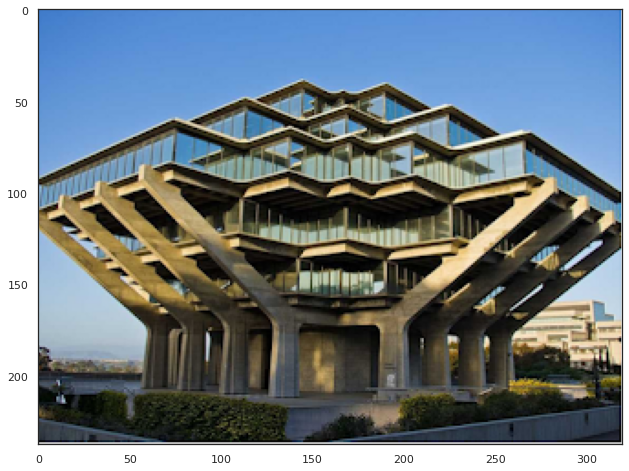

In [3]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [4]:
kernels = dict()
kernels['Identical transformation'] = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # 
kernels['Selecting horizontal borders'] = torch.tensor([[0, 1, 0], [0, -2, 0], [0, 1, 0]])
kernels['Selecting vertical borders'] = torch.tensor([[0, 0, 0], [1, -2, 1], [0, 0, 0]])
kernels['Highlighting borders'] = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
kernels['Sharpening'] = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kernels['Blur'] = torch.tensor([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]])
kernels['Contrast'] = torch.tensor([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
kernels

{'Identical transformation': tensor([[0, 0, 0],
         [0, 1, 0],
         [0, 0, 0]]),
 'Selecting horizontal borders': tensor([[ 0,  1,  0],
         [ 0, -2,  0],
         [ 0,  1,  0]]),
 'Selecting vertical borders': tensor([[ 0,  0,  0],
         [ 1, -2,  1],
         [ 0,  0,  0]]),
 'Highlighting borders': tensor([[ 0,  1,  0],
         [ 1, -4,  1],
         [ 0,  1,  0]]),
 'Sharpening': tensor([[ 0, -1,  0],
         [-1,  5, -1],
         [ 0, -1,  0]]),
 'Blur': tensor([[0.0625, 0.1250, 0.0625],
         [0.1250, 0.2500, 0.1250],
         [0.0625, 0.1250, 0.0625]]),
 'Contrast': tensor([[-1, -1, -1],
         [-1,  9, -1],
         [-1, -1, -1]])}

manual filters


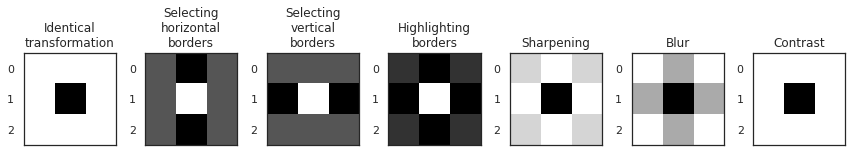

In [5]:
print('manual filters')
fig, axes = plt.subplots(1, 7, figsize=(12, 6))
for ax, (desc, kernel) in zip(axes.flatten(), kernels.items()):
    ax.imshow(kernel, cmap='binary')
    ax.set_xticks([])
    ax.set_title(desc.replace(' ','\n'))
plt.tight_layout()
plt.show()

Apply these convolutions to the image, we get activation maps.

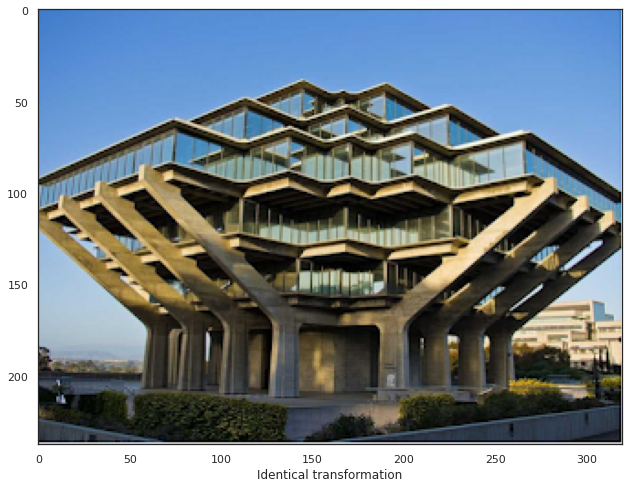

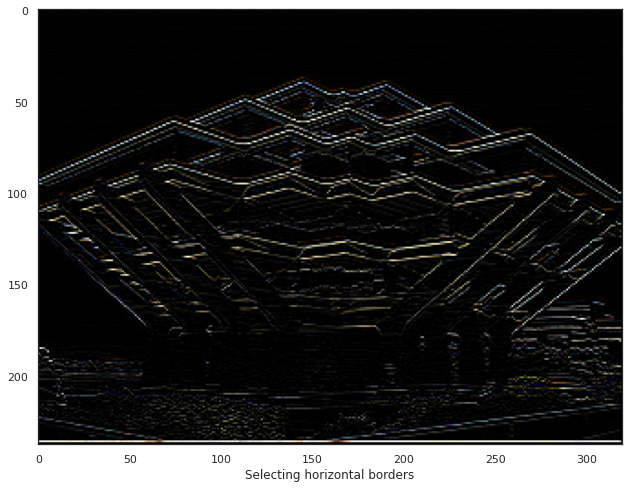

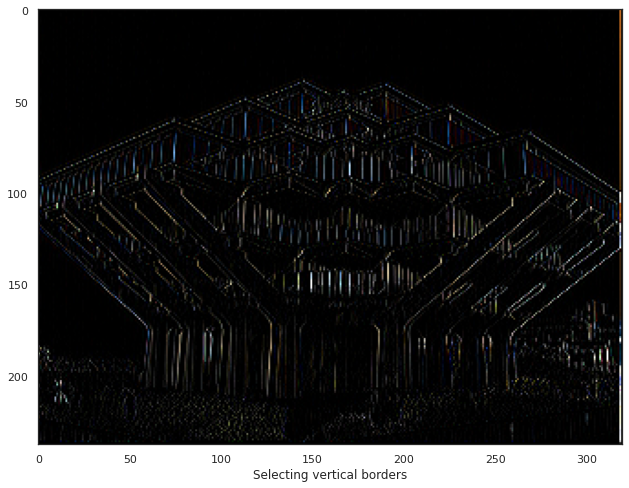

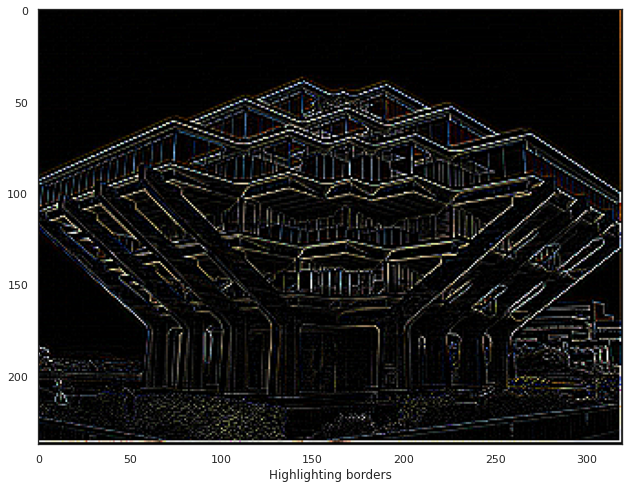

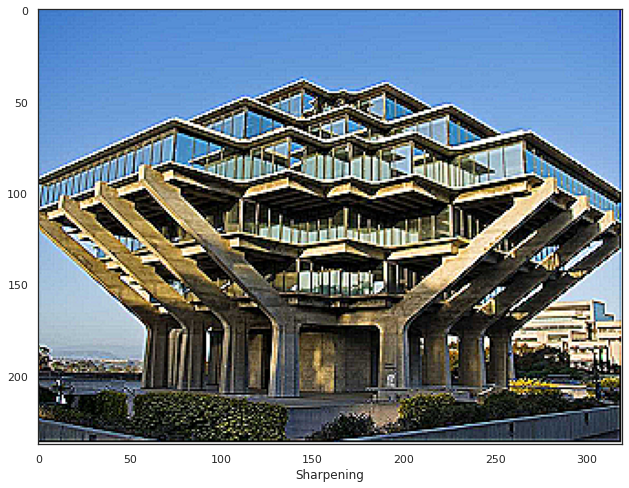

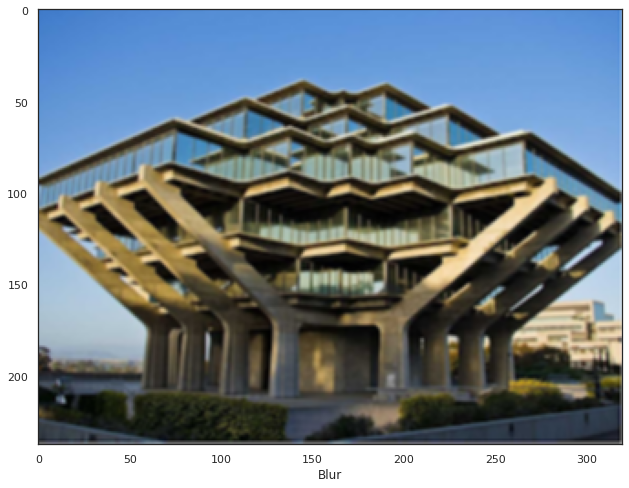

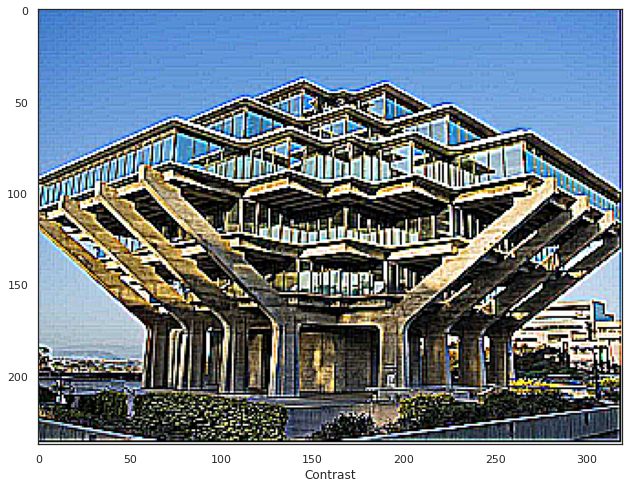

In [6]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(3, 0, 1, 2)
img_t = nn.ReflectionPad2d(1)(img_t)

for letter, kernel in kernels.items():
    kernel = kernel.reshape(1, 1, 3, 3).type(torch.float32)

    div = kernel.sum().item()
    if div == 0:
        div = 1

    result = F.conv2d(img_t, kernel)
    result = (result.squeeze().permute(1, 2, 0).numpy() / div).astype(np.int)

    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.xlabel(letter)
    plt.show()

Imagine the learning process in your head.

For example, we have a network of one convolution as a feature extractor and one neuron as a classifier. This convolution is called a feature extractor, followed by a fully linked layer classifier. It weighs the last activation card and makes a prediction based on the amount of data entered.

We need to distinguish images 0 from 1. Zero is so round, and one is a stick from top to bottom.

The filter contains some initial values ​​(for example, small random values).
We have a loss function like squared error or cross entropy. First, its significance is great because we are wrong.

We start to give examples for input, the network learns, changes convolution and neuron using backpropagation

The convolution gradually turns, for example, into a shape similar to the selection of vertical lines (or into some other shape necessary for the task - this is the beauty of the fact that we cannot interpret the filter strictly), and the classifier also learns by weighting the activation of the input values in this filter. The losses decrease until we start getting meaningful values.

Now let's look at a real example.

# Data loading

In [7]:
# look at files

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [8]:
# some constants

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 128

In [9]:
# load data to pandas dataframe, split into images and their classes

dataset_train = pd.read_csv("../input/digit-recognizer/train.csv")
dataset_train_labels = dataset_train.label
dataset_train_images = dataset_train.drop('label', axis=1)

# split labeled dataset into train and validation parts

dataset = TensorDataset(
    torch.Tensor(dataset_train_images.values / 255),
    torch.LongTensor(dataset_train_labels.values),
)
dataset_tr, dataset_val = train_test_split(dataset, train_size=0.8)

# make loader - its really comfortable

dataloader_train = DataLoader(dataset_tr, batch_size=BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(dataset_val, batch_size=BATCH_SIZE)

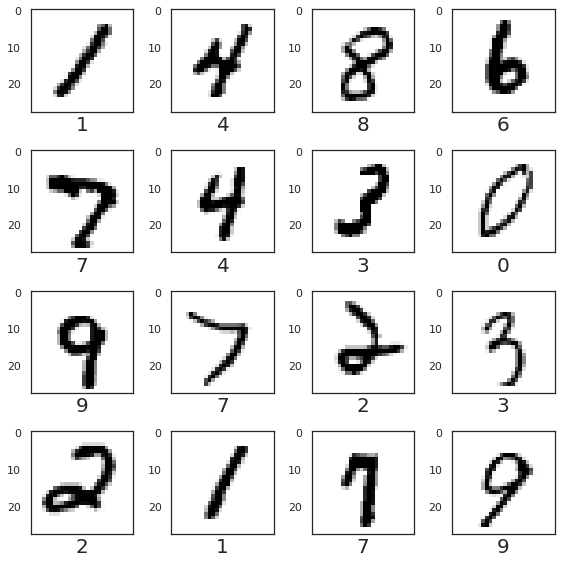

In [10]:
# let's take some images and look at them 

images, labels = next(iter(dataloader_train))
images = images.numpy().reshape(BATCH_SIZE, 28, 28)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for ax, img, img_cls in zip(axes.flatten(), images, labels.numpy()):
    ax.imshow(img, cmap='binary')
    ax.set_xticks([])
    ax.set_xlabel(int(img_cls), fontsize=20)
plt.tight_layout()
plt.show()

# LeNet

**LeNet** is a convolutional neural network structure proposed by Yann LeCun et al. in 1989. In general, LeNet refers to LeNet-5 and is a simple convolutional neural network. Convolutional neural networks are a kind of feed-forward neural network whose artificial neurons can respond to a part of the surrounding cells in the coverage range and perform well in large-scale image processing.
![LeNet](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-52-17.png)

In [11]:
# describe LeNet model

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train model

In [12]:
# use CrossEntropyLoss for multiclass classification and 'Adam' optimizer as good default choise

model = LeNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": dataloader_train, "valid": dataloader_valid}

In [13]:
# train model

max_epochs = 10

losses = {"train": [], "valid": []}
accuracies = {"train": [], "valid": []}

for epoch in range(max_epochs):
    print(f"Epoch: {epoch+1}")
    for phase, dataloader in loaders.items():
        epoch_loss, epoch_correct, epoch_all = 0, 0, 0
        for images, labels in dataloader:
            images = images.reshape(images.shape[0], 1, 28, 28)
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            if phase == "train":
                model.train()
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    output = model(images)
                    loss = criterion(output, labels)
            preds = output.argmax(-1)
            correct =  (preds == labels).sum()
            epoch_loss += loss.item() * BATCH_SIZE
            epoch_correct += correct.item()
            epoch_all += BATCH_SIZE
        
        print('DataLoader: {}. Loss: {}. Accuracy: {}'.format(
            phase, epoch_loss / epoch_all, epoch_correct / epoch_all
        ))
        losses[phase].append(epoch_loss / epoch_all)
        accuracies[phase].append(epoch_correct / epoch_all)

Epoch: 1
DataLoader: train. Loss: 0.6747656003660576. Accuracy: 0.7911715779467681
DataLoader: valid. Loss: 0.25065448451222794. Accuracy: 0.9214015151515151
Epoch: 2
DataLoader: train. Loss: 0.18800691492543928. Accuracy: 0.939638783269962
DataLoader: valid. Loss: 0.1545950002178098. Accuracy: 0.9489820075757576
Epoch: 3
DataLoader: train. Loss: 0.12831269057304687. Accuracy: 0.9577887357414449
DataLoader: valid. Loss: 0.12179984869153211. Accuracy: 0.9564393939393939
Epoch: 4
DataLoader: train. Loss: 0.1036547044639125. Accuracy: 0.9657200570342205
DataLoader: valid. Loss: 0.09501357514862761. Accuracy: 0.9659090909090909
Epoch: 5
DataLoader: train. Loss: 0.08580907432808622. Accuracy: 0.970888783269962
DataLoader: valid. Loss: 0.0864112585726561. Accuracy: 0.9678030303030303
Epoch: 6
DataLoader: train. Loss: 0.07265703176845842. Accuracy: 0.9753742870722434
DataLoader: valid. Loss: 0.07652019068711635. Accuracy: 0.970407196969697
Epoch: 7
DataLoader: train. Loss: 0.0629050029342562.

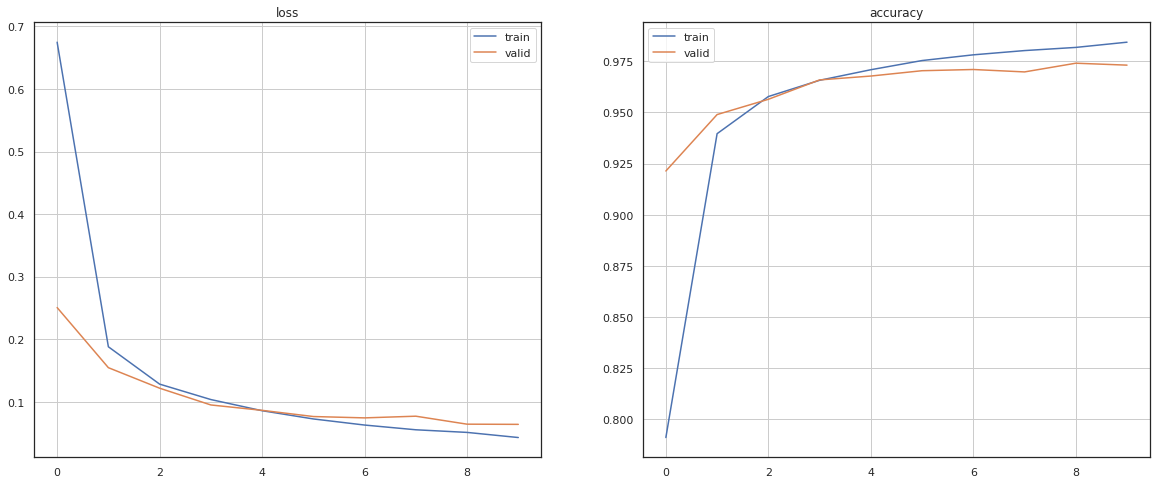

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# look at loss function...

axes[0].plot(losses['train'], label='train')
axes[0].plot(losses['valid'], label='valid')
axes[0].grid()
axes[0].legend()
axes[0].set_title('loss')

# ...and accuracy.

axes[1].plot(accuracies['train'], label='train')
axes[1].plot(accuracies['valid'], label='valid')
axes[1].grid()
axes[1].legend()
axes[1].set_title('accuracy')

plt.show()

# Predict

In [15]:
# load test data

dataset_test = pd.read_csv("../input/digit-recognizer/test.csv")
dataloader_test = DataLoader(torch.Tensor(dataset_test.values / 255), batch_size=1)

In [16]:
# predict classes for test dataset

preds = []
model.eval()
for image in dataloader_test:
    image = image.reshape(image.shape[0], 1, 28, 28)
    image = image.to(DEVICE)
    output = model(image)
    pred = output.argmax(-1)
    preds.append(int(pred))

In [17]:
# form submission file

# submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv', index_col='ImageId')
# submission['Label'] = preds
# submission.to_csv('./submission.csv')

This simple convolutional network (one of the first) puts you right in the middle of the leaderboard. You can now use this baseline to reschedule your workout and easily climb much higher.

BEST SCORE 0.98503 

Look at my another notebooks, e.g. [Intro to PyTorch Transfer Learnining](https://www.kaggle.com/imcr00z/intro-to-pytorch-transfer-learnining). Then we will try to increase the score.

# Visualize Kernels

The convolutional network consists of an feature extractor and a classifier.

The kernels that the network uses and trains may not be understood by humans, but they are suitable for transforming an image into a set of features. These features are then fed to the input of the classifier, and already by training it, we get the probability of the class.

The darker the pixel, the higher the value. During training, the network forms 3x3 filters and after training they do not change. These filters highlight important features.

convolution layer 1


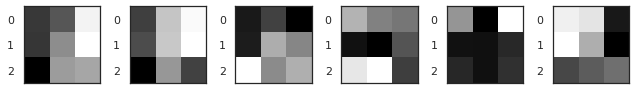

convolution layer 2


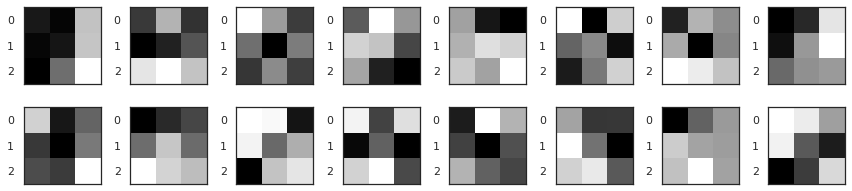

In [18]:
# look at the trained filters

print('convolution layer 1')
fig, axes = plt.subplots(1, 6, figsize=(9, 2))
for ax, kernel in zip(axes.flatten(), model.conv1.weight):
    ax.imshow(kernel[0, :, :].detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
plt.tight_layout()
plt.show()


print('convolution layer 2')
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for ax, kernel in zip(axes.flatten(), model.conv2.weight):
    ax.imshow(kernel[0, :, :].detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
plt.tight_layout()
plt.show()

During training, the network forms 3x3 filters and after training they do not change. These filters highlight important features.

At the first level, these are simple signs - straight lines, turns - the network itself learns what needs to be highlighted.

# Visualize Feature Maps

By applying trained filters to the image, we get level 1 activation maps. Based on the level 1 activation maps and the level 2 filters, we get more general characteristics. Having weighed these cards, the classifier can already understand what this figure is.

These are resizable maps with “highlighted” features. Try to play with the code, enter a different number and see.

We then send the maps to a second level of filters, where they highlight some of the more general characteristics specific to the dataset.
You should understand that we are not setting filters manually - they are generated.

In [19]:
# make hooks to intercept the activation map

feature_map = dict()

def get_feature_map_conv1():
    def hook(model, input, output):
        feature_map['conv1'] = output.detach()
    return hook

def get_feature_map_conv2():
    def hook(model, input, output):
        feature_map['conv2'] = output.detach()
    return hook

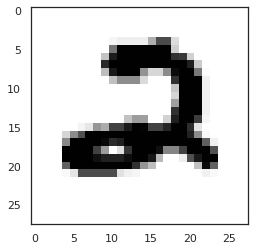

In [20]:
# take the map when predicting (with forward distribution)

model.conv1.register_forward_hook(get_feature_map_conv1())
model.conv2.register_forward_hook(get_feature_map_conv2())
model.eval()
image = next(iter(dataloader_test))
image = image.reshape(image.shape[0], 1, 28, 28)
image = image.to(DEVICE)
output = model(image)

# show image

plt.imshow(image.detach().cpu().numpy().reshape(28, 28), cmap='binary')
plt.show()

In [21]:
feature_map['conv1'].shape, feature_map['conv2'].shape

(torch.Size([1, 6, 26, 26]), torch.Size([1, 16, 11, 11]))

convolution layer 1


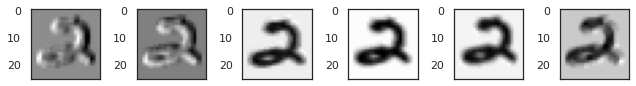

convolution layer 2


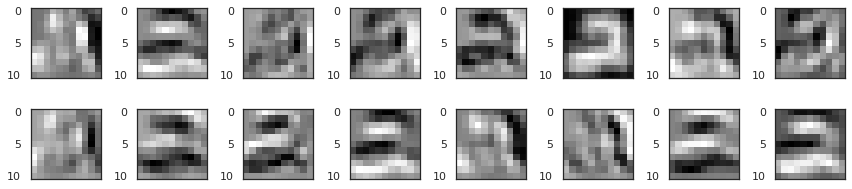

In [22]:
# look at feature maps

print('convolution layer 1')
fig, axes = plt.subplots(1, 6, figsize=(9, 2))
for ax, fmap in zip(axes.flatten(), feature_map['conv1'].squeeze()):
    ax.imshow(fmap.detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
plt.tight_layout()
plt.show()


print('convolution layer 2')
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for ax, fmap in zip(axes.flatten(), feature_map['conv2'].squeeze()):
    ax.imshow(fmap.detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
plt.tight_layout()
plt.show()

Each pixel of these maps is associated with a fully connected classifier layer (look at the model, yes, with 400 neurons of the first classifier layer). By weighing these pixels, the classifier on the second layer receives 120 values, then 84, then 10 class probabilities.

# High score

So, we need a high score to rank high in the competition. Let's take a network like in my notebook [Intro to PyTorch Transfer Learnining](https://www.kaggle.com/imcr00z/intro-to-pytorch-transfer-learnining).

Let's take the alexnet architecture and slightly change it for our task:
* resize the convolutions as our 28x28px image will collapse to 0 by default
* let's change the classifier - we don't need such a powerful one, and the main number of weights is in the fully connected part

In [23]:
alexnet = torchvision.models.alexnet()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Then I will change it a little, uncomment the first, second, third design in turn (I will leave the rest commented out). See how the introduction of additional layers changes the speed of learning, the quality of predictions, and how this affects overfit. Look at the charts.

In [24]:
# alexnet = nn.Sequential(
#     nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
#     nn.ReLU(inplace=True),
    
#     nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    
#     nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#     nn.ReLU(inplace=True),
    
#     nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    
#     nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#     nn.ReLU(inplace=True),
    
#     nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#     nn.ReLU(inplace=True),
    
#     nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1)),
#     nn.ReLU(inplace=True),
    
#     nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    
#     nn.Flatten(),
#     nn.Linear(in_features=2304, out_features=10, bias=True)
# )

Here I put batch norms after the convolutions, this slightly improves the quality.

In [25]:
# alexnet = nn.Sequential(
#     nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
#     nn.BatchNorm2d(64),
#     nn.ReLU(inplace=True),
    
#     nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),

#     nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#     nn.BatchNorm2d(192),
#     nn.ReLU(inplace=True),

#     nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),

#     nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#     nn.BatchNorm2d(384),
#     nn.ReLU(inplace=True),

#     nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#     nn.BatchNorm2d(256),
#     nn.ReLU(inplace=True),

#     nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1)),
#     nn.BatchNorm2d(256),
#     nn.ReLU(inplace=True),
 
#     nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    
#     nn.Flatten(),
#     nn.Linear(in_features=2304, out_features=10, bias=True)
# )

Dropouts have been added here. This increases training time but improves quality.

In [26]:
alexnet = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Dropout(0.5),

    nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(192),
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Dropout(0.5),

    nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(384),
    nn.ReLU(inplace=True),

    nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),

    nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Dropout(0.5),

    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=10, bias=True)
)

In [27]:
alexnet = alexnet.to(DEVICE)

In [28]:
!pip install torchsummary
from torchsummary import summary

In [29]:
summary(alexnet, input_size=(1, 28, 28), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 26, 26]           1,664
       BatchNorm2d-2          [128, 64, 26, 26]             128
              ReLU-3          [128, 64, 26, 26]               0
         MaxPool2d-4          [128, 64, 12, 12]               0
           Dropout-5          [128, 64, 12, 12]               0
            Conv2d-6         [128, 192, 12, 12]         110,784
       BatchNorm2d-7         [128, 192, 12, 12]             384
              ReLU-8         [128, 192, 12, 12]               0
         MaxPool2d-9           [128, 192, 5, 5]               0
          Dropout-10           [128, 192, 5, 5]               0
           Conv2d-11           [128, 384, 5, 5]         663,936
      BatchNorm2d-12           [128, 384, 5, 5]             768
             ReLU-13           [128, 384, 5, 5]               0
           Conv2d-14           [128, 25

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters())
loaders = {"train": dataloader_train, "valid": dataloader_valid}
# train model
max_epochs = 20
losses = {"train": [], "valid": []}
accuracies = {"train": [], "valid": []}

for epoch in range(max_epochs):
    print(f"Epoch: {epoch+1}")
    for phase, dataloader in loaders.items():
        epoch_loss, epoch_correct, epoch_all = 0, 0, 0
        for images, labels in dataloader:
            images = images.reshape(images.shape[0], 1, 28, 28)
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            if phase == "train":
                alexnet.train()
                optimizer.zero_grad()
                output = alexnet(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
            else:
                alexnet.eval()
                with torch.no_grad():
                    output = alexnet(images)
                    loss = criterion(output, labels)
            preds = output.argmax(-1)
            correct =  (preds == labels).sum()
            epoch_loss += loss.item() * BATCH_SIZE
            epoch_correct += correct.item()
            epoch_all += BATCH_SIZE
        
        print('DataLoader: {}. Loss: {}. Accuracy: {}'.format(
            phase, epoch_loss / epoch_all, epoch_correct / epoch_all
        ))
        losses[phase].append(epoch_loss / epoch_all)
        accuracies[phase].append(epoch_correct / epoch_all)

Epoch: 1
DataLoader: train. Loss: 0.44880209745619687. Accuracy: 0.8585729562737643
DataLoader: valid. Loss: 0.12176832929253578. Accuracy: 0.9544270833333334
Epoch: 2
DataLoader: train. Loss: 0.1033631380463281. Accuracy: 0.9659279942965779
DataLoader: valid. Loss: 0.04301556283220028. Accuracy: 0.9815340909090909
Epoch: 3
DataLoader: train. Loss: 0.08399862423716219. Accuracy: 0.9715423003802282
DataLoader: valid. Loss: 0.0714249753633119. Accuracy: 0.9719460227272727
Epoch: 4
DataLoader: train. Loss: 0.06994092730830066. Accuracy: 0.9762951520912547
DataLoader: valid. Loss: 0.03542672988612938. Accuracy: 0.9825994318181818
Epoch: 5
DataLoader: train. Loss: 0.059274581974521. Accuracy: 0.980453897338403
DataLoader: valid. Loss: 0.04701578924538229. Accuracy: 0.9805871212121212
Epoch: 6
DataLoader: train. Loss: 0.05339973258782362. Accuracy: 0.9817015209125475
DataLoader: valid. Loss: 0.05143399373628199. Accuracy: 0.9785748106060606
Epoch: 7
DataLoader: train. Loss: 0.055149758524551

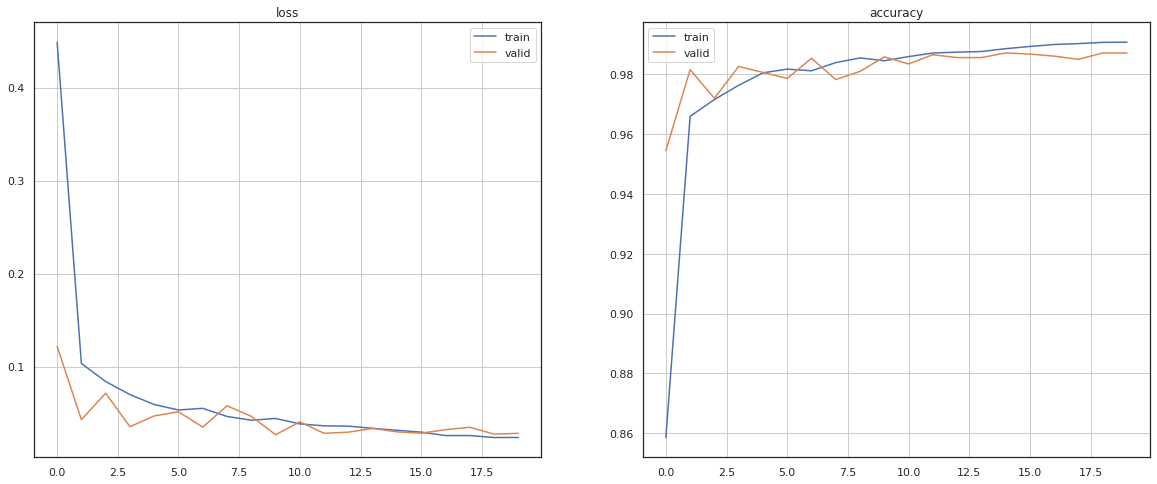

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# look at loss function...

axes[0].plot(losses['train'], label='train')
axes[0].plot(losses['valid'], label='valid')
axes[0].grid()
axes[0].legend()
axes[0].set_title('loss')

# ...and accuracy.

axes[1].plot(accuracies['train'], label='train')
axes[1].plot(accuracies['valid'], label='valid')
axes[1].grid()
axes[1].legend()
axes[1].set_title('accuracy')

plt.show()

In [32]:
# preds = []
# alexnet.eval()
# for image in dataloader_test:
#     image = image.reshape(image.shape[0], 1, 28, 28)
#     image = image.to(DEVICE)
#     output = alexnet(image)
#     pred = output.argmax(-1)
#     preds.append(int(pred))
# submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv', index_col='ImageId')
# submission['Label'] = preds
# submission.to_csv('./submission.csv')

BEST SCORE 0.99160

Most likely, with the current data, it is unlikely that it will be possible to significantly improve the quality. You need augmentation to the dataset, try this.

# Augmentations

In [33]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = x.reshape(1, 28,28)
            x = self.transform(x)
            x = x.flatten()
        y = self.tensors[1][index]
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [34]:
transform = tfs.Compose([
    tfs.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
    tfs.Normalize(0.5, 0.5)
])

In [35]:
dataset = CustomTensorDataset(tensors=(
    torch.Tensor(dataset_train_images.values),
    torch.LongTensor(dataset_train_labels.values)
), transform=transform)
dataset_tr, dataset_val = train_test_split(dataset, train_size=0.8)
dataloader_train = DataLoader(dataset_tr, batch_size=BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(dataset_val, batch_size=BATCH_SIZE)

In [36]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Dropout(0.5),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Dropout(0.5),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256, bias=True),
    nn.Dropout(0.5),
    nn.Linear(in_features=256, out_features=10, bias=True)
)

In [37]:
model = model.to(DEVICE)
summary(model, input_size=(1, 28, 28), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 26, 26]           1,664
       BatchNorm2d-2          [128, 64, 26, 26]             128
              ReLU-3          [128, 64, 26, 26]               0
            Conv2d-4          [128, 64, 24, 24]         102,464
       BatchNorm2d-5          [128, 64, 24, 24]             128
              ReLU-6          [128, 64, 24, 24]               0
         MaxPool2d-7          [128, 64, 11, 11]               0
           Dropout-8          [128, 64, 11, 11]               0
            Conv2d-9          [128, 64, 11, 11]          36,928
      BatchNorm2d-10          [128, 64, 11, 11]             128
             ReLU-11          [128, 64, 11, 11]               0
           Conv2d-12          [128, 64, 11, 11]          36,928
      BatchNorm2d-13          [128, 64, 11, 11]             128
             ReLU-14          [128, 64,

In [38]:
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": dataloader_train, "valid": dataloader_valid}
# train model
max_epochs = 50
losses = {"train": [], "valid": []}
accuracies = {"train": [], "valid": []}

for epoch in range(max_epochs):
    print(f"Epoch: {epoch+1}")
    for phase, dataloader in loaders.items():
        epoch_loss, epoch_correct, epoch_all = 0, 0, 0
        for images, labels in dataloader:
            images = images.reshape(images.shape[0], 1, 28, 28)
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            if phase == "train":
                model.train()
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    output = model(images)
                    loss = criterion(output, labels)
            preds = output.argmax(-1)
            correct =  (preds == labels).sum()
            epoch_loss += loss.item() * BATCH_SIZE
            epoch_correct += correct.item()
            epoch_all += BATCH_SIZE
        
        print('DataLoader: {}. Loss: {}. Accuracy: {}'.format(
            phase, epoch_loss / epoch_all, epoch_correct / epoch_all
        ))
        losses[phase].append(epoch_loss / epoch_all)
        accuracies[phase].append(epoch_correct / epoch_all)

Epoch: 1
DataLoader: train. Loss: 0.45419028160576586. Accuracy: 0.8468393536121673
DataLoader: valid. Loss: 0.14276816278244508. Accuracy: 0.9495738636363636
Epoch: 2
DataLoader: train. Loss: 0.13705828136449305. Accuracy: 0.9565411121673004
DataLoader: valid. Loss: 0.0843460803399935. Accuracy: 0.9659090909090909
Epoch: 3
DataLoader: train. Loss: 0.10215413617855469. Accuracy: 0.966254752851711
DataLoader: valid. Loss: 0.07701811902789456. Accuracy: 0.9738399621212122
Epoch: 4
DataLoader: train. Loss: 0.08761409061036636. Accuracy: 0.9710076045627376
DataLoader: valid. Loss: 0.06691249412004695. Accuracy: 0.9750236742424242
Epoch: 5
DataLoader: train. Loss: 0.07590902301026048. Accuracy: 0.9745425380228137
DataLoader: valid. Loss: 0.06268300827253949. Accuracy: 0.9737215909090909
Epoch: 6
DataLoader: train. Loss: 0.0706132727749504. Accuracy: 0.9763842680608364
DataLoader: valid. Loss: 0.056310614592141726. Accuracy: 0.9770359848484849
Epoch: 7
DataLoader: train. Loss: 0.060948192596

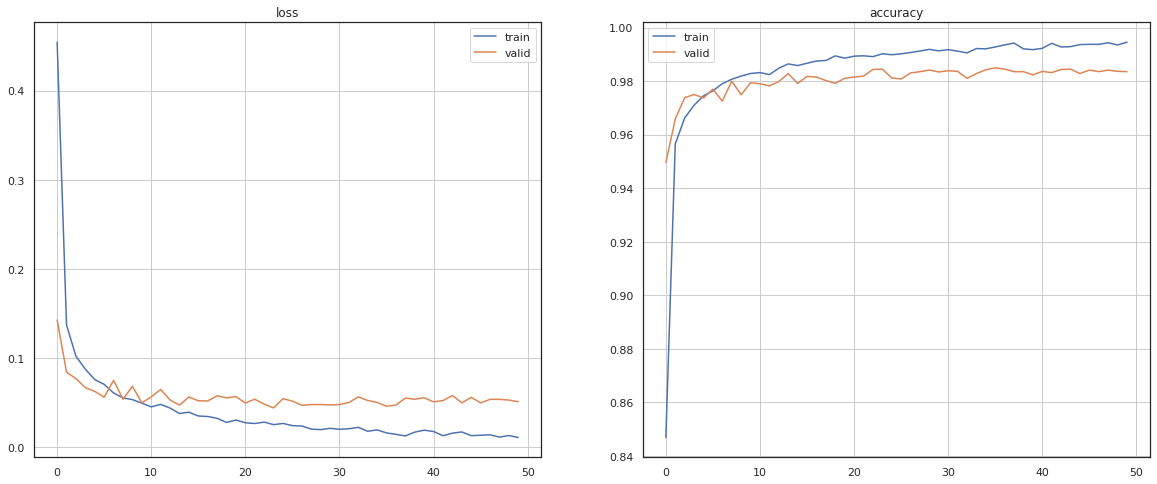

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# look at loss function...

axes[0].plot(losses['train'], label='train')
axes[0].plot(losses['valid'], label='valid')
axes[0].grid()
axes[0].legend()
axes[0].set_title('loss')

# ...and accuracy.

axes[1].plot(accuracies['train'], label='train')
axes[1].plot(accuracies['valid'], label='valid')
axes[1].grid()
axes[1].legend()
axes[1].set_title('accuracy')

plt.show()

In [40]:
preds = []
alexnet.eval()
for image in dataloader_test:
    image = image.reshape(image.shape[0], 1, 28, 28)
    image = image.to(DEVICE)
    output = alexnet(image)
    pred = output.argmax(-1)
    preds.append(int(pred))
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv', index_col='ImageId')
submission['Label'] = preds
submission.to_csv('./submission.csv')